In [8]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset, reconstruction_loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
import pandas as pd
import seaborn as sns
from afqinsight.nn.pt_models import Conv1DAutoencoder



In [ ]:
# FIRST TRACT DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [9]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [10]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [13]:
def train_first_tract_dropout_experiment(
    self, train_data, val_data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE overall

    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0

        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            # For simplicity, using only the first tract in training

            tract_data = x[:, 0:1, :] #keeps it (batch_size, 1, 100)    

            # Apply jitter augmentation
            tract_data = tract_data.to(torch.float32).numpy()
            tract_data = aug.jitter(tract_data, sigma=sigma)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            # Compute RMSE for the batch
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

            # Backward pass
            loss.backward()
            opt.step()

            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                # For simplicity, using the first tract in validation as well
                tract_data = x[:, 0:1, :]

                # Apply jitter augmentation
                
                tract_data = tract_data.to(torch.float32).numpy()
                tract_data = aug.jitter(tract_data, sigma=sigma)
                tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

                # Forward pass
                x_hat = self(tract_data)

                # Compute RMSE for the batch
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)

        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        # Update best validation loss if improved
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss


In [14]:
dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"\nTraining with dropout = {dropout}", f"latent_dim = {latent_dim}")
        vae_one_tract = Conv1DAutoencoder(latent_dims=20, dropout=dropout).to(device)
        train_rmse, val_rmse, best_val_loss = train_first_tract_dropout_experiment(
            vae_one_tract, train_loader, val_loader, epochs=100, lr=1e-3, num_selected_tracts=8
        )
        train_rmse_results[dropout, latent_dim] = train_rmse
        val_rmse_results[dropout, latent_dim] = val_rmse
        best_val_results[dropout, latent_dim] = best_val_loss


Training with dropout = 0 latent_dim = 10
Epoch 1, Train RMSE: 0.1488, Val RMSE: 0.1115
Epoch 2, Train RMSE: 0.0984, Val RMSE: 0.0938
Epoch 3, Train RMSE: 0.0887, Val RMSE: 0.0843
Epoch 4, Train RMSE: 0.0740, Val RMSE: 0.0627
Epoch 5, Train RMSE: 0.0530, Val RMSE: 0.0444
Epoch 6, Train RMSE: 0.0402, Val RMSE: 0.0374
Epoch 7, Train RMSE: 0.0360, Val RMSE: 0.0353
Epoch 8, Train RMSE: 0.0349, Val RMSE: 0.0341
Epoch 9, Train RMSE: 0.0343, Val RMSE: 0.0338
Epoch 10, Train RMSE: 0.0337, Val RMSE: 0.0339


KeyboardInterrupt: 

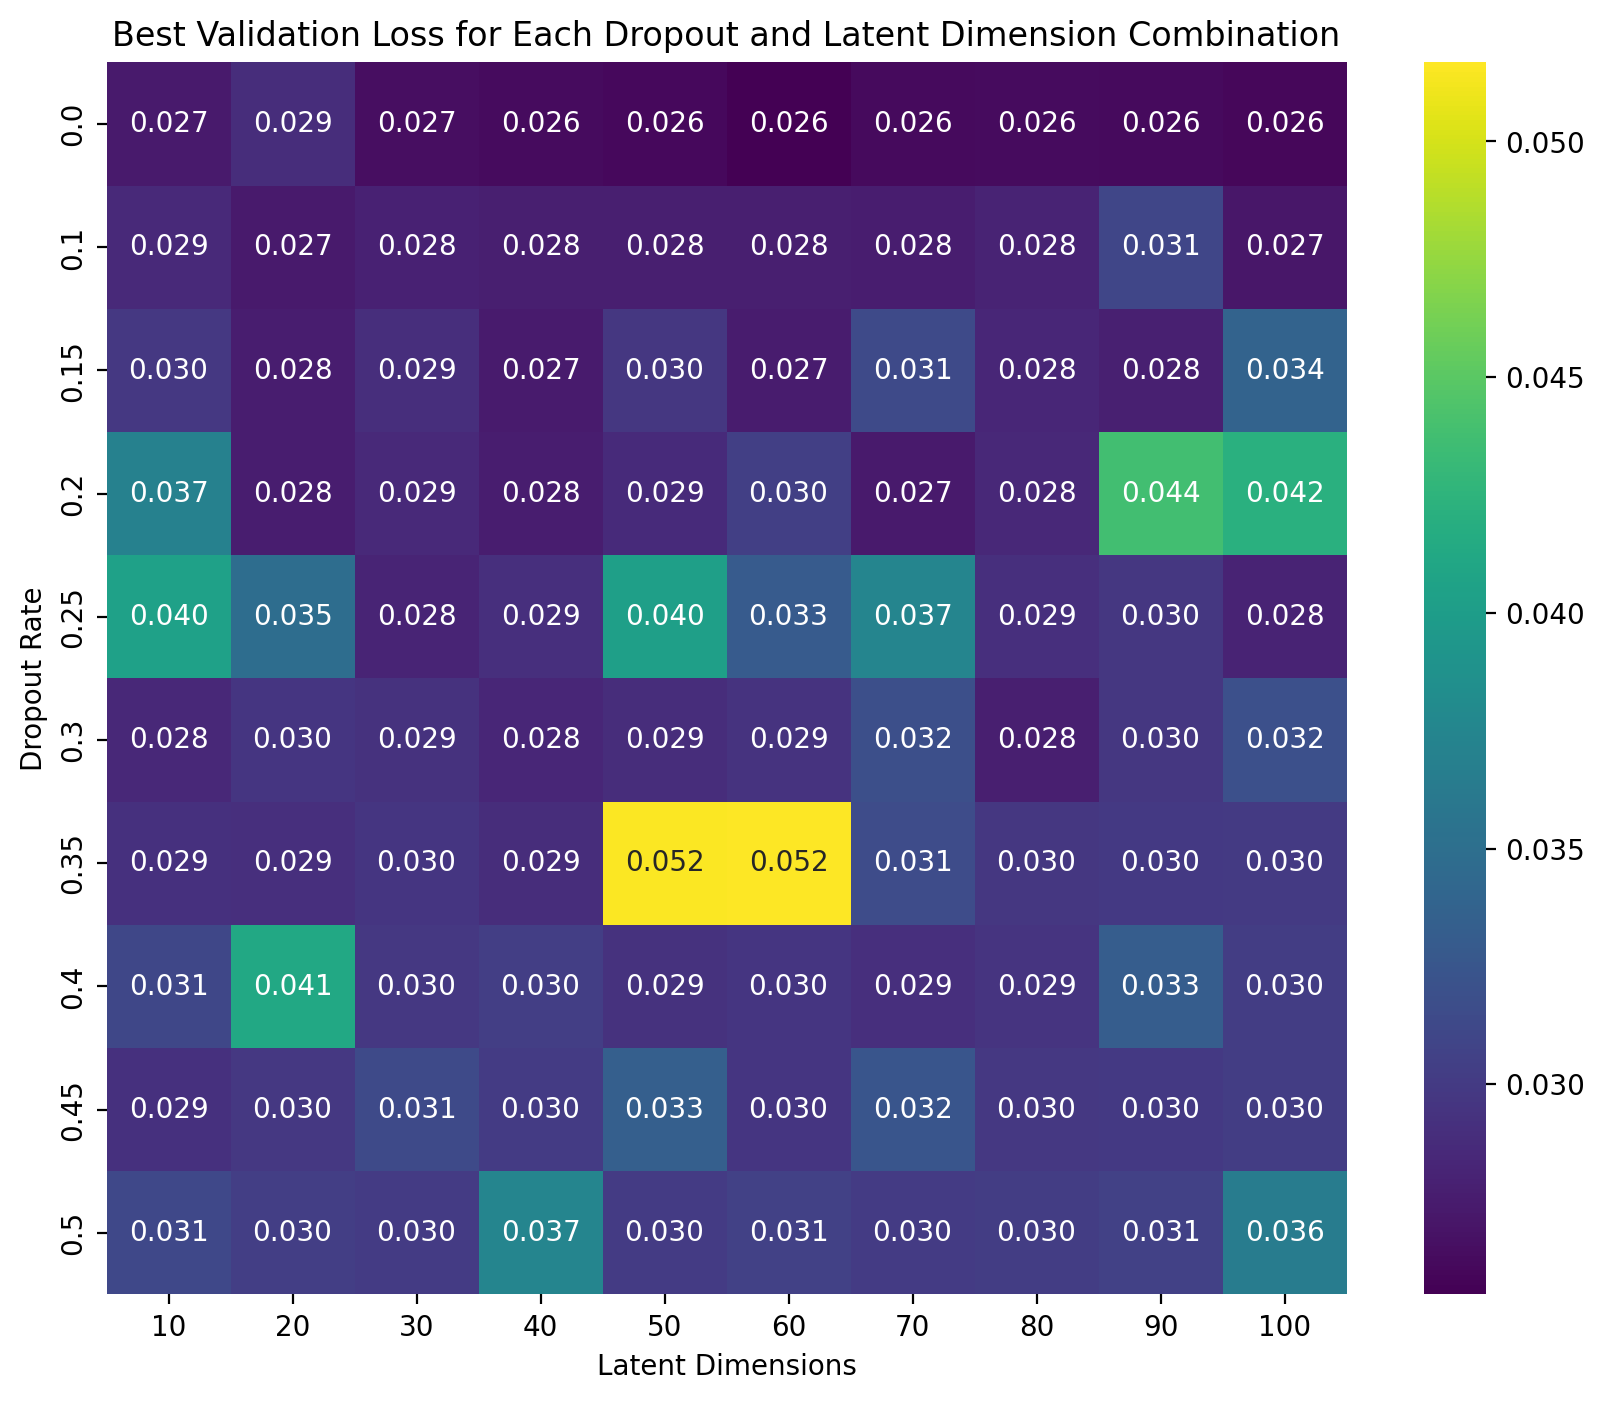

In [ ]:
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation losses
for (dropout, latent_dim), best_val_loss in best_val_results.items():
    df_best_val.loc[dropout, latent_dim] = best_val_loss

# Convert the values to floats (if not already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation Loss for Each Dropout and Latent Dimension Combination")
plt.show()

In [ ]:
# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()



In [ ]:
# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()